First download the list 

In [1]:
import requests
import os

KEY_URL_PROGETTO_RISOLVE = "URL progetto risolve?"
KEY_URL_PROGETTO_FIRST_SEEN = "URL progetto First_Seen"
KEY_URL_PROGETTO_LAST_SEEN = "URL progetto Last_Seen"

dir_path = os.getcwd()

output_csv = os.path.join(dir_path, "list.csv")

# Construct the URL for exporting the sheet in CSV format
export_url = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=38666818"

try:
    # Send a GET request to download the CSV content
    response = requests.get(export_url)
    response.raise_for_status()  # Raise an error for HTTP issues

    with open(output_csv, "wb") as file:
        file.write(response.content)

    print(f"Sheet downloaded successfully and saved to {output_csv}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading the Google Sheet: {e}")

Sheet downloaded successfully and saved to /Users/gspinaci/projects/Vita-e-morte-DH-projects/dataset/input/list.csv


Projects: 269
Projects with dates: 232
Projects with resolving URL: 167


[]

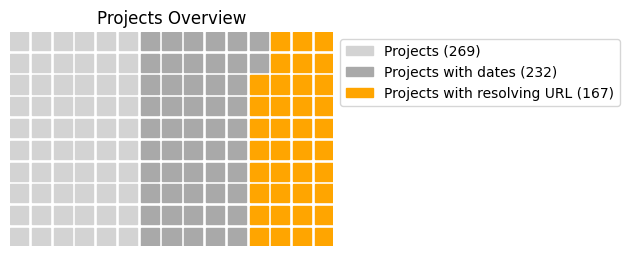

In [29]:
import pandas as pd
import pywaffle as pw
import matplotlib.pyplot as plt

data = pd.read_csv(output_csv)

projects_dates = data[
  (pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce').notna()) &
  (pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce').notna())
]
projects_resolving_url = data[data[KEY_URL_PROGETTO_RISOLVE] == True]

num_projects = len(data)
num_valid_dates = len(projects_dates)
num_resolved_projects = len(projects_resolving_url)

print(f"Projects: {num_projects}")
print(f"Projects with dates: {num_valid_dates}")
print(f"Projects with resolving URL: {num_resolved_projects}")

# Create and store Waffle chart
data = {
  'Projects': num_projects,
  'Projects with dates': num_valid_dates,
  'Projects with resolving URL': num_resolved_projects,
}
fig = plt.figure(
  FigureClass=pw.Waffle,
  rows=10,
  columns=15,
  values=data,
  colors=['lightgrey', 'darkgrey', 'orange'],
  title={'label': 'Projects Overview', 'loc': 'center'},
  labels=[f"{k} ({v})" for k, v in data.items()],
  legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
  block_arranging_style='snake'
)
plt.plot()

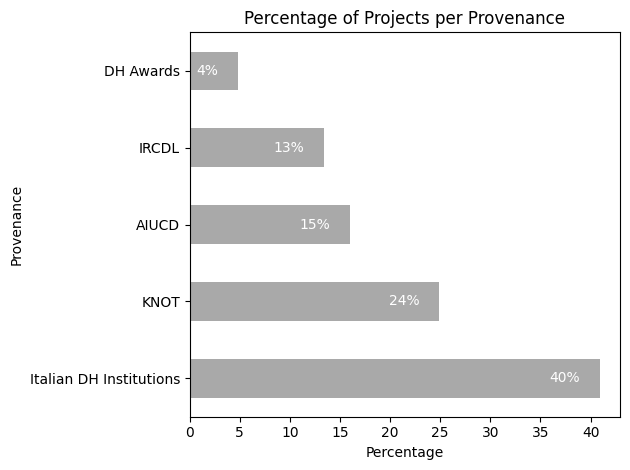

In [30]:
# Calculate the percentage of projects per provenance
data = pd.read_csv(output_csv)
provenance_counts = data['Provenance'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart
fig, ax = plt.subplots()
bars = provenance_counts.plot(kind='barh', ax=ax, color='darkgrey')
ax.set_title('Percentage of Projects per Provenance')
ax.set_xlabel('Percentage')
ax.set_ylabel('Provenance')
plt.tight_layout()

for bar in bars.patches:
  ax.text(bar.get_width() - 2, bar.get_y() + bar.get_height() / 2,
      f'{int(bar.get_width())}%', va='center', ha='right', color='white', fontsize=10)

plt.show()

Get the dead projects. All the projects without URL progetto, or with URL project not resolving

In [31]:
data = pd.read_csv(output_csv)
dead_projects = data[
  (data[KEY_URL_PROGETTO_RISOLVE] == False) &
  (pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce').notna()) &
  (pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce').notna())
]

print(f"Dead projects: {dead_projects.shape[0]}")


Dead projects: 72


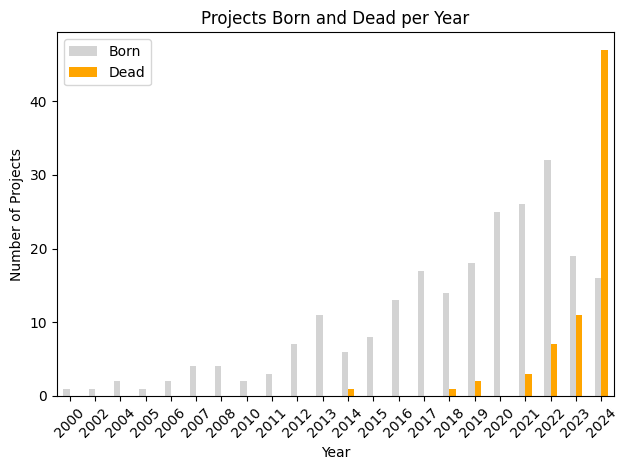

In [32]:
data = pd.read_csv(output_csv)

# Extract the year from the 'First_Seen' and 'Last_Seen' columns
data[KEY_URL_PROGETTO_FIRST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce')
data[KEY_URL_PROGETTO_LAST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce')
data['Year_First_Seen'] = data[KEY_URL_PROGETTO_FIRST_SEEN].dt.year
data['Year_Last_Seen'] = data[KEY_URL_PROGETTO_LAST_SEEN].dt.year

# Calculate born projects
born_projects = data['Year_First_Seen'].value_counts().sort_index()

# Calculate dead projects
dead_projects = data[(data[KEY_URL_PROGETTO_LAST_SEEN].notna()) & (data[KEY_URL_PROGETTO_RISOLVE] == False)]['Year_Last_Seen'].value_counts().sort_index()

# Create a DataFrame for plotting
years = sorted(set(born_projects.index).union(set(dead_projects.index)))
born_counts = [born_projects.get(year, 0) for year in years]
dead_counts = [dead_projects.get(year, 0) for year in years]

df_years = pd.DataFrame({
  'Year': years,
  'Born': born_counts,
  'Dead': dead_counts
})

# Convert 'Year' column to integer for better readability on x-axis
df_years['Year'] = df_years['Year'].astype(int)

# Plot the bar chart
fig, ax = plt.subplots()
df_years.plot(kind='bar', x='Year', y=['Born', 'Dead'], ax=ax, color=['lightgrey', 'orange'])
ax.set_title('Projects Born and Dead per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

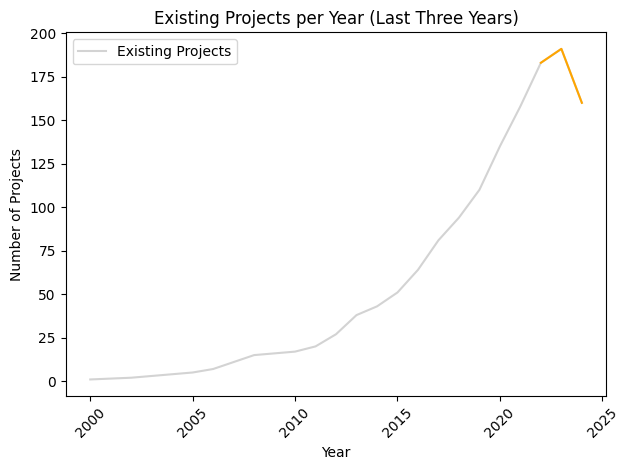

In [33]:
# Plot the line graph for existing projects per year
df_years['Existing'] = df_years.apply(lambda row: row['Born'] - row['Dead'], axis=1).cumsum()

fig, ax = plt.subplots()
ax.plot(df_years['Year'], df_years['Existing'], label='Existing Projects', color='lightgrey')

# Highlight the last three years
highlight_years = df_years.tail(3)
ax.plot(highlight_years['Year'], highlight_years['Existing'], color='orange')

ax.set_title('Existing Projects per Year (Last Three Years)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
ax.yaxis.get_major_locator().set_params(integer=True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [43]:
# Calculate the lifespan of each project

data = pd.read_csv(output_csv)
dead_projects = data[
  (data[KEY_URL_PROGETTO_RISOLVE] == False) &
  (pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce').notna()) &
  (pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce').notna())
].copy()

dead_projects['Lifespan'] = (pd.to_datetime(dead_projects[KEY_URL_PROGETTO_LAST_SEEN]) - pd.to_datetime(dead_projects[KEY_URL_PROGETTO_FIRST_SEEN])).dt.days

valid_lifespans = dead_projects['Lifespan'].dropna()
mean_lifespan_days = valid_lifespans.mean()
mean_lifespan_years = mean_lifespan_days / 365

print(f"Mean lifespan of the dead projects: {mean_lifespan_years:.2f} years")

Mean lifespan of the dead projects: 4.45 years
